In [1]:
import pandas as pd
from pathlib import Path

def extract_data(file_path,row_start,row_end):
    # Read the dataset
    df = pd.read_csv(file_path)
    
   
    new_df = df.iloc[row_start:row_end]
    
    return new_df

# Example usage
file_path = Path(r'DataSets\GDP_Data_Set_24.csv')
new_dataset_yearly = extract_data(file_path, 7, 83)
new_dataset_yearly.columns = ["Year", "GDP in Millions"]
yearly_gdp_path = Path('DataSets\yearly_GDP.csv')
new_dataset_yearly.to_csv(yearly_gdp_path, index=False)

def rename_year_quarter(df):
    # Define a custom date parsing function
    def parse_quarter(year_quarter_str):
        year, quarter = year_quarter_str.split(' Q')
        month = int(quarter) * 3  # Months: 3, 6, 9, 12
        return pd.Timestamp(year=int(year), month=month, day=1) + pd.offsets.MonthEnd(0)

    # Apply the parsing function
    df['Date'] = df['Year and Quarter'].apply(parse_quarter)
    return df

# Example usage
new_dataset_quarterly = extract_data(file_path, 83, 362)
new_dataset_quarterly.columns = ["Year and Quarter", "GDP in Millions"]
new_dataset_quarterly = rename_year_quarter(new_dataset_quarterly)
quarterly_gdp_path = Path('DataSets\quarterly_GDP.csv')
new_dataset_quarterly.to_csv(quarterly_gdp_path, index=False)



<>:17: SyntaxWarning: invalid escape sequence '\y'
<>:35: SyntaxWarning: invalid escape sequence '\q'
<>:17: SyntaxWarning: invalid escape sequence '\y'
<>:35: SyntaxWarning: invalid escape sequence '\q'
C:\Users\jacob\AppData\Local\Temp\ipykernel_10764\1322180501.py:17: SyntaxWarning: invalid escape sequence '\y'
  yearly_gdp_path = Path('DataSets\yearly_GDP.csv')
C:\Users\jacob\AppData\Local\Temp\ipykernel_10764\1322180501.py:35: SyntaxWarning: invalid escape sequence '\q'
  quarterly_gdp_path = Path('DataSets\quarterly_GDP.csv')


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

def extract_data(file_path, row_start, row_end):
    # Read the dataset
    df = pd.read_csv(file_path)
    new_df = df.iloc[row_start:row_end]
    return new_df

def rename_year_quarter(df):
    # Define a custom date parsing function
    def parse_quarter(year_quarter_str):
        year, quarter = year_quarter_str.split(' Q')
        month = int(quarter) * 3  # Months: 3, 6, 9, 12
        return pd.Timestamp(year=int(year), month=month, day=1) + pd.offsets.MonthEnd(0)

    # Apply the parsing function
    df['Date'] = df['Year and Quarter'].apply(parse_quarter)
    return df

def interpolate_monthly_gdp(quarterly_df):
    # Ensure the Date column is sorted
    quarterly_df = quarterly_df.sort_values('Date')
    quarterly_df['GDP in Millions'] = quarterly_df['GDP in Millions'].astype(float)
    
    # Create a monthly date range
    start_date = quarterly_df['Date'].min()
    end_date = quarterly_df['Date'].max()
    monthly_dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    
    # Interpolate GDP for monthly dates
    monthly_df = pd.DataFrame({'Date': monthly_dates})
    monthly_df = pd.merge(monthly_df, quarterly_df, on='Date', how='left')
    monthly_df['GDP in Millions'] = monthly_df['GDP in Millions'].interpolate(method='linear')
    
    return monthly_df

def extend_gdp_predictions(monthly_df, annual_growth_rate, forecast_years):
    last_gdp = monthly_df['GDP in Millions'].iloc[-1]
    last_date = monthly_df['Date'].iloc[-1]
    future_data = []

    for year in range(forecast_years):
        for month in range(1, 13):
            new_date = last_date + pd.DateOffset(months=1)
            growth_factor = 1 + annual_growth_rate / 100
            last_gdp *= growth_factor ** (1 / 12)  # Apply monthly growth rate
            future_data.append({'Date': new_date, 'GDP in Millions': last_gdp})
            last_date = new_date  # Increment the date
    
    # Convert the future data into a DataFrame and concatenate
    future_df = pd.DataFrame(future_data)
    monthly_df = pd.concat([monthly_df, future_df], ignore_index=True)
    
    return monthly_df

# Example usage
file_path = Path(r'DataSets\GDP_Data_Set_24.csv')

# Add error handling to the main process
try:
    # Step 1: Extract Quarterly Data
    quarterly_data = extract_data(file_path, 83, 362)
    quarterly_data.columns = ["Year and Quarter", "GDP in Millions"]
    
    # Check for valid data
    if quarterly_data.empty:
        raise ValueError("Quarterly data is empty. Check the file content or path.")
    
    quarterly_data = rename_year_quarter(quarterly_data)

    # Step 2: Interpolate Monthly GDP
    monthly_gdp = interpolate_monthly_gdp(quarterly_data)

    # Step 3: Extend Predictions
    annual_growth = 4.7  # Example: 4.7% annual growth
    if not isinstance(annual_growth, (int, float)):
        raise ValueError("Annual growth rate must be a number.")
    
    monthly_gdp_predictions = extend_gdp_predictions(monthly_gdp, annual_growth_rate=annual_growth, forecast_years=2)

    # Save the predictions
    output_path = Path(r'DataSets\monthly_gdp_predictions.csv')
    monthly_gdp_predictions.to_csv(output_path, index=False)
    print("Monthly GDP predictions saved successfully.")

except Exception as e:
    print(f"An error occurred: {e}")


Monthly GDP predictions saved successfully.


In [5]:
quarterly_data= pd.read_csv('DataSets\quarterly_GDP.csv')
monthly_data =pd.read_csv('DataSets\monthly_gdp_predictions.csv')

<>:1: SyntaxWarning: invalid escape sequence '\q'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\q'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jacob\AppData\Local\Temp\ipykernel_10764\279763375.py:1: SyntaxWarning: invalid escape sequence '\q'
  quarterly_data= pd.read_csv('DataSets\quarterly_GDP.csv')
C:\Users\jacob\AppData\Local\Temp\ipykernel_10764\279763375.py:2: SyntaxWarning: invalid escape sequence '\m'
  monthly_data =pd.read_csv('DataSets\monthly_gdp_predictions.csv')


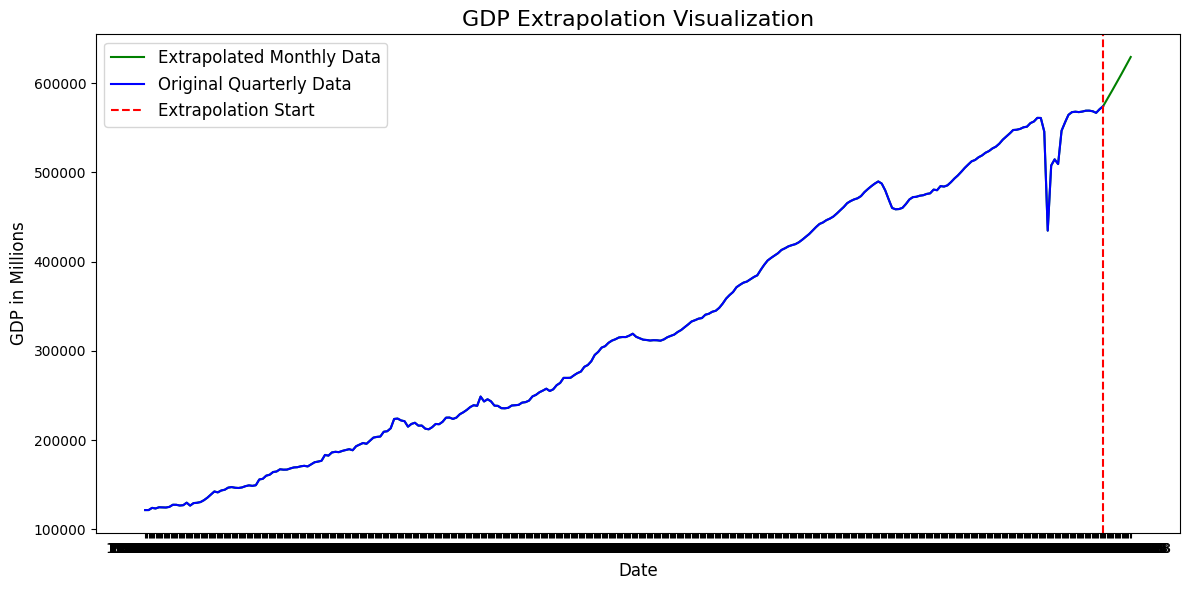

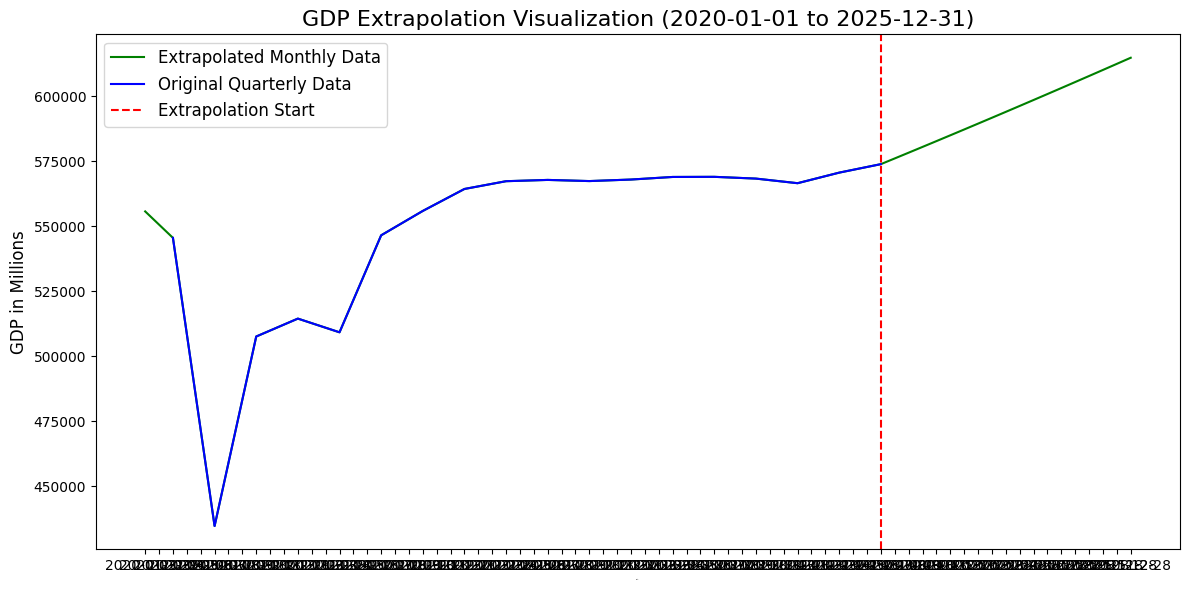

In [6]:
import matplotlib.pyplot as plt

def visualize_gdp_extrapolation(original_df, extrapolated_df):
    """
    Visualize the original GDP data and its extrapolation.

    Parameters:
    - original_df: DataFrame containing the original GDP data (e.g., quarterly data).
    - extrapolated_df: DataFrame containing the extrapolated monthly GDP data.

    Returns:
    - None (displays a plot).
    """
    plt.figure(figsize=(12, 6))
    
    # Plot extrapolated data
    plt.plot(
        extrapolated_df['Date'], 
        extrapolated_df['GDP in Millions'], 
        label='Extrapolated Monthly Data', 
        color='green'
    )

    # Plot original data    
    plt.plot(
        original_df['Date'], 
        original_df['GDP in Millions'], 
        label='Original Quarterly Data', 
        color='blue'
    )

    # Highlight extrapolated region
    last_original_date = original_df['Date'].max()
    plt.axvline(x=last_original_date, color='red', linestyle='--', label='Extrapolation Start')

    # Add labels, legend, and grid
    plt.title('GDP Extrapolation Visualization', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('GDP in Millions', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.tight_layout()

    # Show the plot
    plt.show()

def visualize_zoomed_gdp_extrapolation(original_df, extrapolated_df, start_date, end_date):
    """
    Visualize the original GDP data and its extrapolation within a specific date range.

    Parameters:
    - original_df: DataFrame containing the original GDP data (e.g., quarterly data).
    - extrapolated_df: DataFrame containing the extrapolated monthly GDP data.
    - start_date: The start date for the zoomed-in plot.
    - end_date: The end date for the zoomed-in plot.

    Returns:
    - None (displays a plot).
    """
    plt.figure(figsize=(12, 6))
    
    # Filter data within the specified date range
    mask_original = (original_df['Date'] >= start_date) & (original_df['Date'] <= end_date)
    mask_extrapolated = (extrapolated_df['Date'] >= start_date) & (extrapolated_df['Date'] <= end_date)
    
    original_zoomed = original_df[mask_original]
    extrapolated_zoomed = extrapolated_df[mask_extrapolated]
    
    # Plot extrapolated data
    plt.plot(
        extrapolated_zoomed['Date'], 
        extrapolated_zoomed['GDP in Millions'], 
        label='Extrapolated Monthly Data', 
        color='green'
    )

    # Plot original data    
    plt.plot(
        original_zoomed['Date'], 
        original_zoomed['GDP in Millions'], 
        label='Original Quarterly Data', 
        color='blue'
    )

    # Highlight extrapolated region
    last_original_date = original_zoomed['Date'].max()
    plt.axvline(x=last_original_date, color='red', linestyle='--', label='Extrapolation Start')

    # Add labels, legend, and grid
    plt.title(f'GDP Extrapolation Visualization ({start_date} to {end_date})', fontsize=16)
    plt.xlabel('Date', fontsize=1)
    plt.ylabel('GDP in Millions', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
visualize_gdp_extrapolation(quarterly_data, monthly_data)
visualize_zoomed_gdp_extrapolation(quarterly_data, monthly_data, '2020-01-01', '2025-12-31')
